#  MLPでCIFAR-10

In [1]:
# ====================
# データセットをダウンロード
# ====================

import torch
import torchvision

train = torchvision.datasets.CIFAR10(root="./", train=True, download=True, transform=torchvision.transforms.ToTensor())
test = torchvision.datasets.CIFAR10(root="./", train=False, download=True, transform=torchvision.transforms.ToTensor())

100.0%


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


訓練用： (50000, 32, 32, 3)
評価用： (10000, 32, 32, 3)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


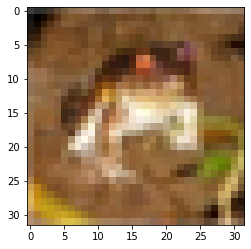

frog


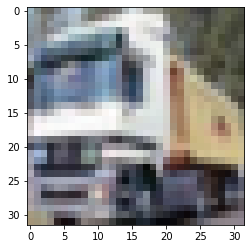

truck


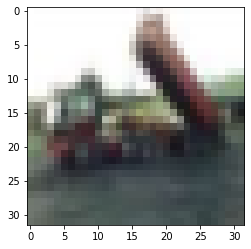

truck


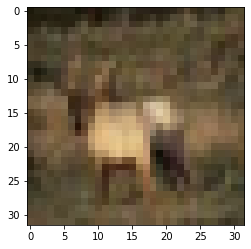

deer


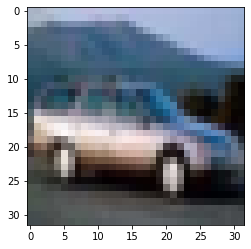

automobile


In [2]:
# ====================
# データの内容を確認
# ====================

import numpy as np
import matplotlib.pyplot as plt

print("訓練用：", train.data.shape)
print("評価用：", test.data.shape)

classes = train.classes
print(classes)

for i in range(5):
    plt.imshow(np.transpose(train[i][0].numpy(), (1, 2, 0)))
    plt.show()
    print(classes[train[i][1]])

In [3]:
# ====================
# 訓練用と評価用の各データをDataLoaderに格納
# ====================

from torch.utils.data import DataLoader

batch_size = 100

train_loader = DataLoader(train, batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size, shuffle=False)

# 2. ネットワークの定義

In [4]:
# ====================
# MLPを定義
# ====================

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    # 使用するオブジェクトを定義
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 10)  # 784ノードの入力層から10ノードの中間層への全結合
        self.fc2 = nn.Linear(10, 10)  # 10ノードの中間層から10ノードの出力層への全結合
    
    # 順伝播
    def forward(self, x):
        h = F.relu(self.fc1(x))  # xを線形変換（fc1）し、非線形変換（relu）し、中間表現hを得る
        y = self.fc2(h)  # 中間表現hを線形変換（fc2）し、出力yを得る
        return y

# ネットワークのインスタンスを作成
net = Net()

# 損失関数
criterion = nn.CrossEntropyLoss()

# 最適化手法
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

# 3. 訓練と評価

In [5]:
# ====================
# モデルをGPUへ転送
# ====================

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = net.to(device)

device

device(type='cuda', index=0)

In [6]:
# ====================
# 訓練ループ
# ====================

max_epoch = 20

for epoch in range(max_epoch):

    # 学習状況の確認用
    total_loss = 0

    # ミニバッチ学習
    for batch in train_loader:

        # バッチサイズ分のサンプルを抽出
        x, t = batch  # 1
        x = x.view(-1, 32*32*3)

        # データをGPUへ転送
        x = x.to(device)
        t = t.to(device)

        # 勾配を初期化
        optimizer.zero_grad()

        # 順伝播
        y = net(x)  # 2
        loss = criterion(y, t)  # 3

        # 誤差逆伝播
        loss.backward()  # 4
        optimizer.step()  # 5
    
        # 学習状況の確認
        total_loss += loss.item()
    
    print("epoch: %02d    loss: %.3f" % (epoch+1, total_loss))

epoch: 01    loss: 1085.084
epoch: 02    loss: 985.591
epoch: 03    loss: 946.056
epoch: 04    loss: 924.440
epoch: 05    loss: 909.682
epoch: 06    loss: 897.484
epoch: 07    loss: 889.491
epoch: 08    loss: 881.567
epoch: 09    loss: 874.846
epoch: 10    loss: 869.420
epoch: 11    loss: 864.455
epoch: 12    loss: 859.869
epoch: 13    loss: 856.266
epoch: 14    loss: 852.493
epoch: 15    loss: 849.166
epoch: 16    loss: 846.139
epoch: 17    loss: 842.856
epoch: 18    loss: 841.579
epoch: 19    loss: 838.237
epoch: 20    loss: 836.221


In [7]:
# ====================
# 正解率の計算
# ====================
nb_classes = 10

In [8]:
confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():

    accs = list()
    labels = list()

    for batch in test_loader:
        x, t = batch
        x = x.view(-1, 32*32*3)
        x = x.to(device)
        t = t.to(device)
        y = net(x)

        label = torch.argmax(y, dim=1)
        for t_conf, p in zip(t.view(-1), label.view(-1)):
            confusion_matrix[t_conf.long(), p.long()] += 1

        acc = (label == t).sum() * 1.0 / len(t)
        accs.append(acc)
        labels.extend(label)

print("正解率: %.3f" % torch.tensor(accs).mean())
print(confusion_matrix.to(torch.int64))

正解率: 0.404
tensor([[570,  41,  60,  28,  29,  12,  21,  70, 123,  46],
        [ 81, 552,   9,  23,  28,  21,  35,  59,  63, 129],
        [126,  45, 219,  65, 202,  61, 126, 118,  21,  17],
        [ 46,  69, 123, 207,  70, 164, 144,  94,  28,  55],
        [ 76,  35, 120,  39, 362,  33, 141, 159,  16,  19],
        [ 45,  54, 120, 127,  84, 281,  97, 139,  32,  21],
        [ 13,  28,  91,  86, 154,  62, 473,  55,  11,  27],
        [ 67,  54,  67,  37, 109,  54,  39, 504,  13,  56],
        [243, 101,  28,  28,  26,  20,   8,  21, 430,  95],
        [100, 209,  13,  17,  13,  20,  48,  79,  61, 440]])


[[570.  41.  60.  28.  29.  12.  21.  70. 123.  46.]
 [ 81. 552.   9.  23.  28.  21.  35.  59.  63. 129.]
 [126.  45. 219.  65. 202.  61. 126. 118.  21.  17.]
 [ 46.  69. 123. 207.  70. 164. 144.  94.  28.  55.]
 [ 76.  35. 120.  39. 362.  33. 141. 159.  16.  19.]
 [ 45.  54. 120. 127.  84. 281.  97. 139.  32.  21.]
 [ 13.  28.  91.  86. 154.  62. 473.  55.  11.  27.]
 [ 67.  54.  67.  37. 109.  54.  39. 504.  13.  56.]
 [243. 101.  28.  28.  26.  20.   8.  21. 430.  95.]
 [100. 209.  13.  17.  13.  20.  48.  79.  61. 440.]]


<AxesSubplot:>

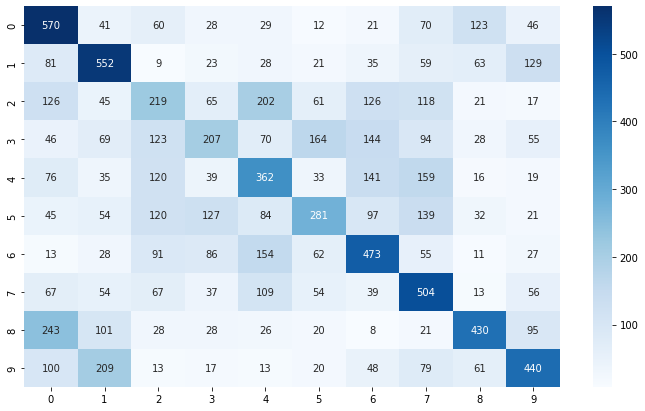

In [9]:
import pandas as pd
import seaborn as sn

confusion_matrix_numpy = confusion_matrix.to('cpu').detach().numpy().copy()
print(confusion_matrix_numpy)
df_cmx = pd.DataFrame(confusion_matrix_numpy)
plt.figure(figsize= (12,7))
sn.heatmap(df_cmx, annot=True, fmt='g', cmap='Blues')

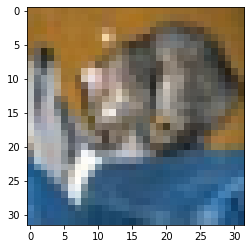

Gold: cat  Pred: cat


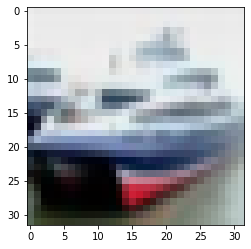

Gold: ship  Pred: truck


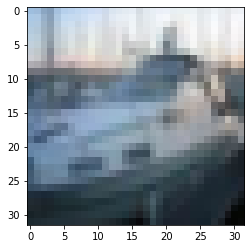

Gold: ship  Pred: ship


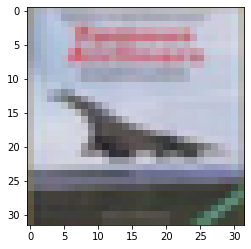

Gold: airplane  Pred: airplane


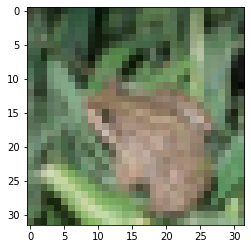

Gold: frog  Pred: deer


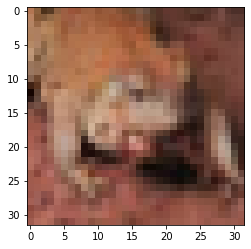

Gold: frog  Pred: frog


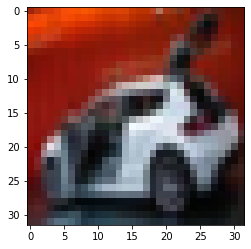

Gold: automobile  Pred: cat


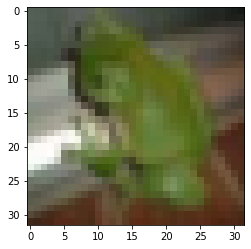

Gold: frog  Pred: frog


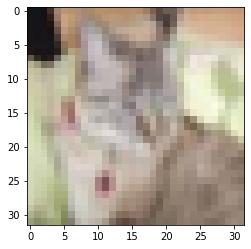

Gold: cat  Pred: bird


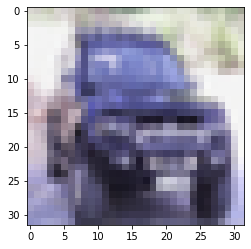

Gold: automobile  Pred: automobile


In [10]:
# ====================
# 実例の確認
# ====================

for i in range(10):
    plt.imshow(np.transpose(test[i][0].numpy(), (1, 2, 0)))
    plt.show()
    print("Gold: %s  Pred: %s" % (classes[test[i][1]], classes[labels[i]]))